In [262]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from model import DenseNet121, CLASS_NAMES  # Importing the model and class names from model.py


In [263]:
import sys
print(sys.executable)


C:\Users\zafer\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


In [264]:
# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hooks to save activations and gradients
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
    # Compute the weights
        weights = self.gradients.mean(dim=[0, 2, 3]).to(self.activation.device)  # Ensure weights are on the same device as activation
        activation = self.activation.squeeze(0).detach()

    # Initialize the heatmap on the correct device
        heatmap = torch.zeros(activation.shape[1:], device=activation.device)

    # Compute the weighted sum of activations
        for i, w in enumerate(weights):
            heatmap += w * activation[i]

    # Apply ReLU to remove negative values
        heatmap = torch.clamp(heatmap, min=0)
        return heatmap.cpu().numpy()  # Move to CPU for visualization


In [265]:
checkpoint = torch.load(CKPT_PATH)
print("Checkpoint keys:", checkpoint.keys())


Checkpoint keys: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'val_loss'])


C:\Users\zafer\AppData\Local\Temp\ipykernel_21408\3403221778.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CKPT_PATH)


In [266]:
import torch

CLASS_NAMES = [ 'Atelectasis', 'Effusion', 'Infiltration', 'Nodule', 'Pneumothorax', "No Finding"]
# Path to the pre-trained model checkpoint
N_CLASSES = len(CLASS_NAMES)  # Number of classes
CKPT_PATH = 'zaferemre-model.pth.tar'

# Initialize DenseNet121 model
model = DenseNet121(N_CLASSES)

# Modify the input layer to accept 1-channel input (grayscale)
model.densenet121.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Load the checkpoint
checkpoint = torch.load(CKPT_PATH)
state_dict = checkpoint["model_state_dict"]

# Map keys to match DenseNet format (if necessary)
new_state_dict = {}
for k, v in state_dict.items():
    # Adjust ResNet keys to DenseNet keys (if needed)
    new_key = k
    if k.startswith("conv1"):
        new_key = k.replace("conv1", "densenet121.features.conv0")
    elif k.startswith("bn1"):
        new_key = k.replace("bn1", "densenet121.features.norm0")
    elif k.startswith("fc"):
        new_key = k.replace("fc", "classifier")
    new_state_dict[new_key] = v

# Load modified state_dict into the model (skip strict matching to avoid conflicts)
model.load_state_dict(new_state_dict, strict=False)

# Set model to evaluation mode
model.eval()

print("Model loaded successfully with adjusted input layer!")



Model loaded successfully with adjusted input layer!


C:\Users\zafer\AppData\Local\Temp\ipykernel_21408\676070865.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CKPT_PATH)


In [267]:
# Identify the target layer for Grad-CAM
target_layer = model.densenet121.features[-1]  # Last convolutional layer of DenseNet121
grad_cam = GradCAM(model, target_layer)


In [268]:
import os
import random
from PIL import Image
import torch

# Paths
test_list_path = "ChestX-ray14/Combined_Train_and_Test_Data.csv"
image_dir = "C:/Users/zafer/OneDrive/Masaüstü/Dev/cnn-in-nih14-old/dataset/images-1024/images-1024"

# Define class names
CLASS_NAMES = ["Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "No Finding"]

import os
import random

def get_random_image_and_findings(test_list_path, image_dir, class_names):
    """
    Randomly selects an image and its associated findings from the dataset.

    Parameters:
    - test_list_path (str): Path to the dataset CSV file.
    - image_dir (str): Directory containing the images.
    - class_names (list): List of disease class names.

    Returns:
    - random_image_file (str): Full path to the randomly selected image.
    - findings (list): List of findings associated with the image.
    """
    # Load the test list and parse data
    if not os.path.exists(test_list_path):
        raise FileNotFoundError(f"Test list file not found at {test_list_path}")

    with open(test_list_path, "r") as f:
        lines = f.readlines()

    # Ensure the file is not empty
    if not lines:
        raise ValueError("Test list is empty.")

    # Extract header and rows
    header = lines[0].strip().split(",")  # Assumes the first row is the header
    rows = lines[1:]  # Remaining lines are data

    # Find the column indices for 'Image Index' and 'Finding Labels'
    if "Image Index" not in header or "Finding Labels" not in header:
        raise ValueError("Required columns 'Image Index' or 'Finding Labels' are not found in the header.")

    image_index_col = header.index("Image Index")
    findings_col = header.index("Finding Labels")

    # Extract image file paths and findings
    image_data = []
    for row in rows:
        columns = row.strip().split(",")
        image_file = os.path.join(image_dir, columns[image_index_col])
        findings_raw = columns[findings_col]
        findings = [finding.strip().capitalize() for finding in findings_raw.split("|")] if findings_raw != "No Finding" else []
        image_data.append((image_file, findings))

    # Pick a random image and its findings
    random_image_file, findings = random.choice(image_data)

    return random_image_file, findings


In [269]:
import torch
from torchvision import transforms
from PIL import Image

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize([0.485], [0.229])  # Normalize for grayscale images (1 channel)
])

# Load and preprocess the image
img = Image.open(random_image_file).convert("L")  # Open as grayscale
input_tensor = transform(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")  # Add batch dimension and move to GPU if available

print(f"Transformed image tensor shape: {input_tensor.shape}")


Transformed image tensor shape: torch.Size([1, 1, 224, 224])


In [270]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Move the input tensor to the same device
input_tensor = input_tensor.to(device)

# Perform forward pass
output = model(input_tensor)

# Select a target class for visualization
target_classes = [CLASS_NAMES.index(finding) for finding in findings if finding in CLASS_NAMES]

# Zero gradients
model.zero_grad()

# Perform backward pass for each target class
for target_class in target_classes:
    output[0, target_class].backward(retain_graph=True)  # Retain graph for multiple backward passes
    print(f"Gradients computed for target class: {CLASS_NAMES[target_class]}")

Gradients computed for target class: Nodule


Selected random image file: C:/Users/zafer/OneDrive/Masaüstü/Dev/cnn-in-nih14-old/dataset/images-1024/images-1024\00015072_012.png
Findings: ['Atelectasis', 'Effusion', 'Infiltration']


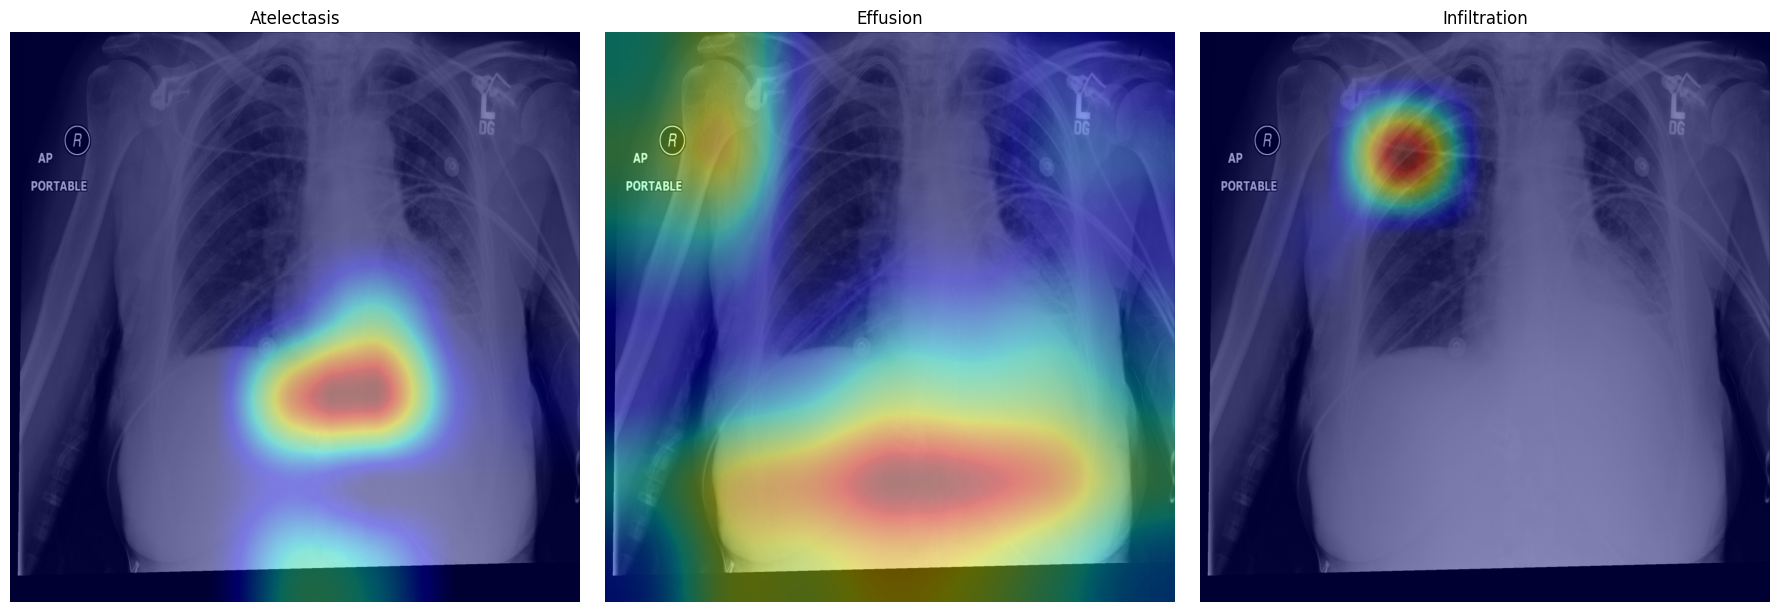

In [280]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

random_image_file, findings = get_random_image_and_findings(TEST_LIST_PATH, IMAGE_DIR, CLASS_NAMES)

# Ensure findings and image path from the previous step
print(f"Selected random image file: {random_image_file}")
print(f"Findings: {findings if findings else 'No findings detected'}")

if not findings:
    print("No findings detected for the selected image. Exiting Grad-CAM visualization.")
else:
    # Load and preprocess the selected image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])  # Assuming grayscale image
    ])
    img = Image.open(random_image_file).convert("L")  # Open as grayscale
    input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Dynamically set the target layer
    target_layer = model.densenet121.features.denseblock4  # Default to denseblock4

    # Allow user to experiment with other layers
    # target_layer = model.densenet121.features.denseblock3
    # target_layer = model.densenet121.features.transition3

# Attach hooks to the selected layer
    gradients = None
    activations = None

    def save_gradients(module, grad_input, grad_output):
        global gradients
        gradients = grad_output[0]

    def save_activations(module, input, output):
        global activations
        activations = output

    target_layer.register_forward_hook(save_activations)
    target_layer.register_backward_hook(save_gradients)

# Perform Grad-CAM (rest of your Grad-CAM code)


    # Perform forward pass for the selected image
    output = model(input_tensor)  # Forward pass for the selected image

    # Ensure output is for the selected image
    if output.shape[0] != 1:
        raise ValueError("Output does not match the selected image. Ensure batch size is 1.")

    # Zero gradients
    model.zero_grad()

    # Create subplots for Grad-CAM visualizations
    fig, axes = plt.subplots(1, len(findings), figsize=(6 * len(findings), 6))

    # Ensure axes is a list even if there's only one subplot
    if len(findings) == 1:
        axes = [axes]

    # Generate Grad-CAM for each detected disease
    for idx, disease in enumerate(findings):
        if disease not in CLASS_NAMES:
            print(f"Skipping unknown disease: {disease}")
            continue

        target_class = CLASS_NAMES.index(disease)  # Get the class index for the disease

        # Perform backward pass for the target class
        output[0, target_class].backward(retain_graph=True)

        # Generate Grad-CAM heatmap
        weights = torch.mean(gradients, dim=(2, 3))  # Average gradients over spatial dimensions
        grad_cam = torch.sum(weights[:, :, None, None] * activations, dim=1).squeeze()

        # Detach from computational graph and normalize
        grad_cam = grad_cam.clamp(min=0).detach().cpu().numpy()  # Detach before converting to NumPy
        grad_cam /= grad_cam.max()  # Normalize heatmap

        # Resize heatmap to match the image size
        heatmap_resized = Image.fromarray((grad_cam * 255).astype(np.uint8)).resize(img.size, Image.BICUBIC)

        # Convert heatmap to an array
        heatmap_array = np.array(heatmap_resized)

        # Expand the grayscale image to 3 channels
        img_array = np.array(img).astype(np.float32)
        if len(img_array.shape) == 2:  # Check if grayscale
            img_array = np.stack([img_array] * 3, axis=-1)  # Convert to 3 channels

        # Blend the heatmap with the original image
        heatmap_overlay = (img_array * 0.6 + plt.cm.jet(heatmap_array / 255.0)[:, :, :3] * 255 * 0.4).astype(np.uint8)

        # Display the Grad-CAM heatmap in the subplot
        axes[idx].imshow(heatmap_overlay)
        axes[idx].axis("off")
        axes[idx].set_title(f"{disease}", fontsize=12)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
